In [1]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.auto import tqdm
from pandas.io.formats.style import Styler
import math

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost.callback import EarlyStopping

import catboost as cat
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import log_loss

from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [2]:
""" Load DatatFrame & Fixed Column Name """  

PATH_ORIGIN = '/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv'
PATH_TRAIN = '/kaggle/input/playground-series-s3e10/train.csv'
PATH_TEST = '/kaggle/input/playground-series-s3e10/test.csv'
PATH_SUB = '/kaggle/input/playground-series-s3e10/sample_submission.csv'

origin = pd.read_csv(PATH_ORIGIN)
train = pd.read_csv(PATH_TRAIN).drop(columns='id')
test = pd.read_csv(PATH_TEST).drop(columns='id')

In [3]:
""" Check General Information about each DataFrame """
print(f'original dataframe: {origin.info()}', end='\n\n')
print(f'train dataframe: {train.info()}', end='\n\n')
print(f'test dataframe: {test.info()}', end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Mean_Integrated       17898 non-null  float64
 1   SD                    17898 non-null  float64
 2   EK                    17898 non-null  float64
 3   Skewness              17898 non-null  float64
 4   Mean_DMSNR_Curve      17898 non-null  float64
 5   SD_DMSNR_Curve        17898 non-null  float64
 6   EK_DMSNR_Curve        17898 non-null  float64
 7   Skewness_DMSNR_Curve  17898 non-null  float64
 8   Class                 17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
original dataframe: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Mean_Integrated       117564 non-nul

In [4]:
"""
Check General Statistic Information about each dataframe
All of columns are continuous values
"""
train_feature = [
    'Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
    'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class'
]
for col in train_feature:
    col_name = str(col)
    print(f'{col} unique value counts: {len(train[col_name].unique())}', end = '\n\n')
# train.describe()

Mean_Integrated unique value counts: 11065

SD unique value counts: 49262

EK unique value counts: 37132

Skewness unique value counts: 41366

Mean_DMSNR_Curve unique value counts: 12474

SD_DMSNR_Curve unique value counts: 48050

EK_DMSNR_Curve unique value counts: 42870

Skewness_DMSNR_Curve unique value counts: 50648

Class unique value counts: 2



In [5]:
"""
Check Label Distribution of train dataset, Label Distribution of train dataset are very imbalance 
[Label distribution]
    0: 91%
    1: 9%
Thus, we got a very imbalanced dataset. We are going to use StratifiedKFold
"""
train.Class.value_counts()

0    106597
1     10967
Name: Class, dtype: int64

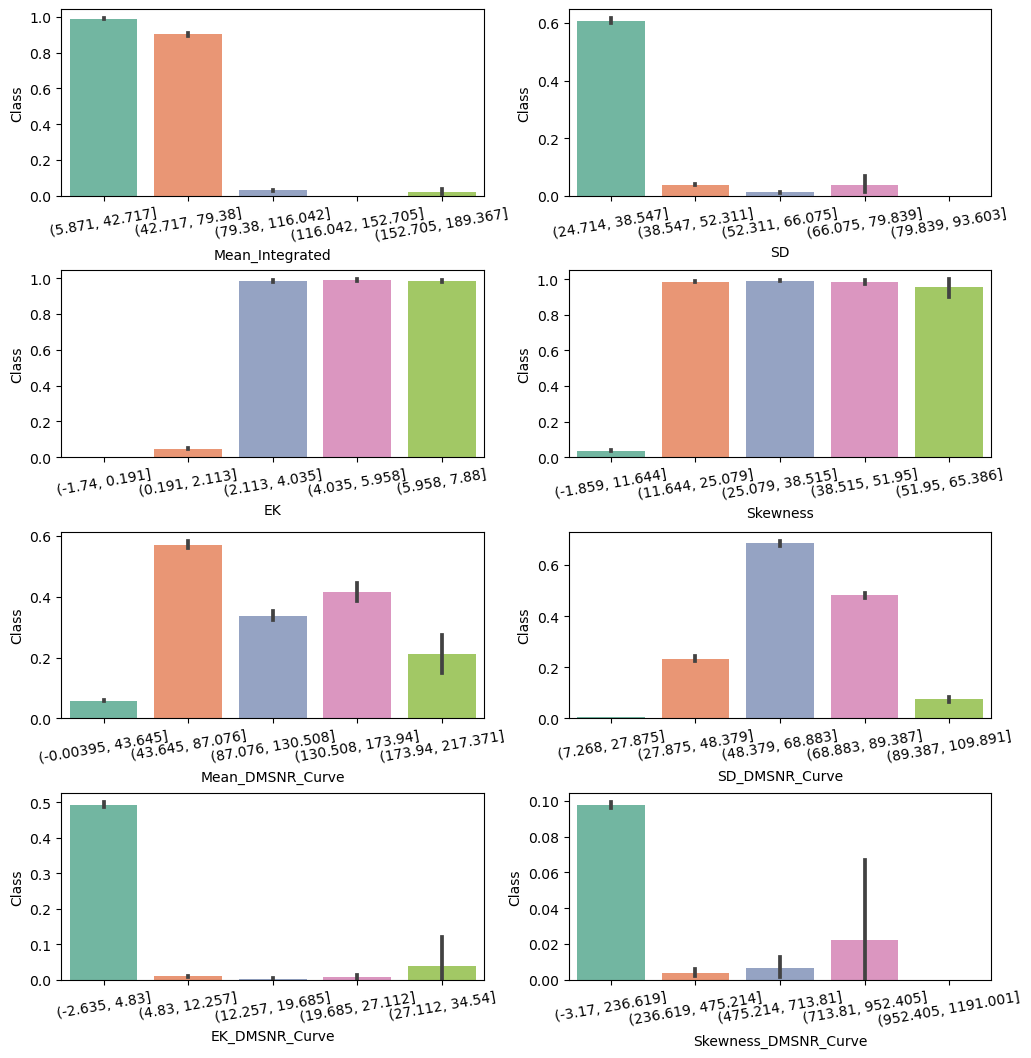

In [6]:
"""
Visualization Target & continuous feature ratio
There are no drop columns, because all of features are explainable for our target class
But if you want to drop col, feature 'skewness' can be candidate
"""
tmp_train = train.copy()
train_feature = [
    'Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
    'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve',
]

plt.figure(figsize=(12, 16))                
grid = gridspec.GridSpec(5, 2)              
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for idx, cont_feature in enumerate(train_feature):
    tmp_train[cont_feature] = pd.cut(train[cont_feature], 5)
    ax = plt.subplot(grid[idx])              
    sns.barplot(x=cont_feature, y='Class', data=tmp_train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전

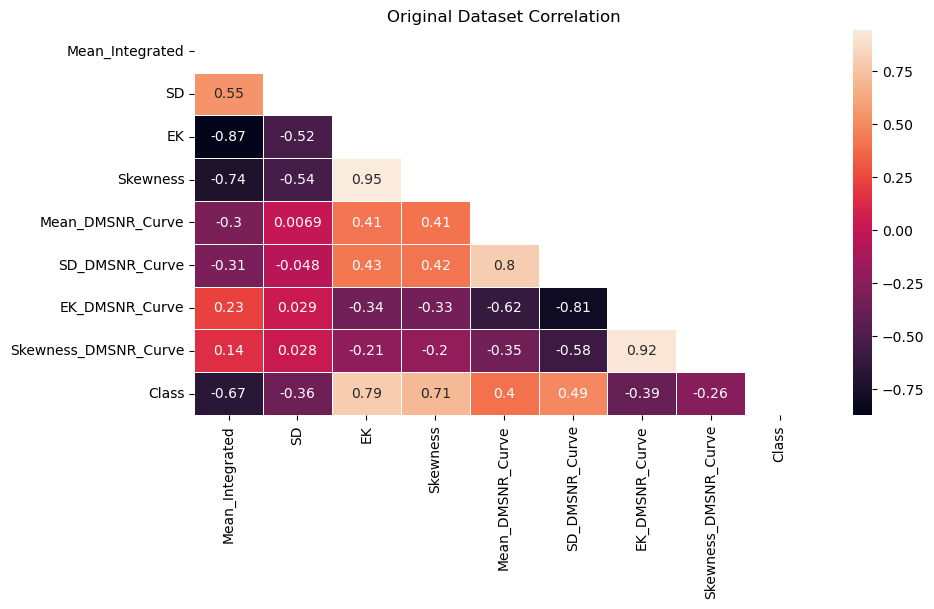

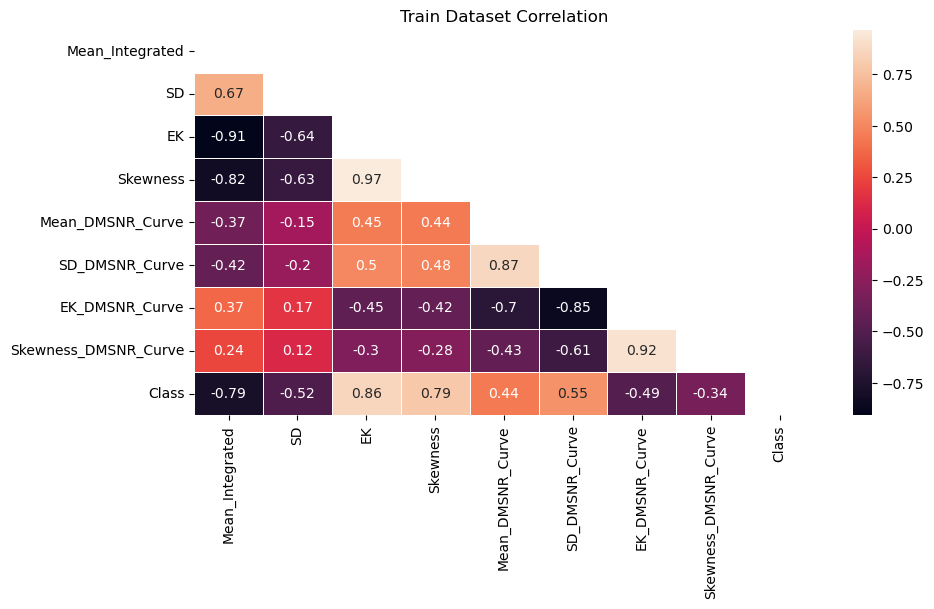

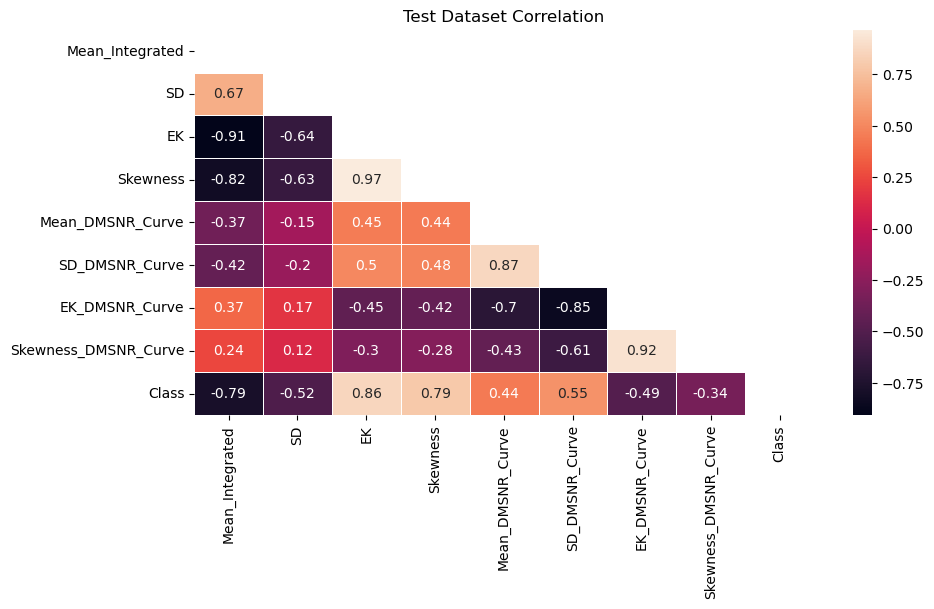

In [7]:
"""
Correlation Analysis, There are a lot of high correlated feature pair in our dataset
So, we will drop some of them
[High Correlated Feature Pair]
    1) Skewness - EK (0)
    2) SD_DMSNR_Curve - Mean_DMSNR_Curve (0)
    3) EK_DMSNR_Curve - SD_DMSNR_Curve (x)
    4) Skewness_DMSNR_Curve - EK_DMSNR_Curve (0)
    5) EK - Mean_Integrated (0)
=> Drop List
    None
"""

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    """Draws the correlation heatmap plot.
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, annot=True)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(origin, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(train, 'Test Dataset Correlation')

In [8]:
"""
This Custom Dataset class implement for two objectives:
    objective 1: combine dataset if you want
    objective 2: do feature extraction 
    Args:
        combined: if you want combine competition train data & original train data, set true
        verbose: if you want to print preprocess result, set true
In this competition, no need to use feature engineering except for drop column
So, if you want to add new strategy, activate this class 
"""
class PulsarDatasetProcessor:
    def __init__(self,
                 train_data=None,
                 test_data=None,
                 combined: bool = False,
                 verbose: bool = False) -> None:
        self.origin_data = None
        self.train_data = train_data
        self.test_data = test_data
        self.combined = combined
        self.verbose = verbose

        if self.verbose:
            print(f'[INFO] Shapes before feature engineering:'
                  f'\n[+] train  -> {self.train_data.shape}'
                  f'\n[+] test   -> {self.test_data.shape}\n')
            
    @staticmethod
    def feature_extraction(df: pd.DataFrame) -> pd.DataFrame:
        """ feature extraction function """
#         df['children_ratio'] = df['total_children']/df['num_children_at_home']
#         df['children_ratio'] = df['children_ratio'].replace([np.inf, -np.inf], 10)
#         df['children_ratio'] = df['children_ratio'].replace([np.nan], 0)

#         df['per_store_sqft'] = df['store_sqft'] / (df['total_children'] + df['avg_cars_at_home'])
#         for idx in range(len(df)):
#             if df.iloc[idx, -1] == (np.inf or -np.inf):
#                 df.iloc[idx, -1] = df.iloc[idx, 10]

        return df

    def process_data(self):
        """ Apply processing to dataframe """
        self.train_data = self.feature_extraction(self.train_data)
        self.test_data = self.feature_extraction(self.test_data)
        if self.combined:
            cols = self.train_data.columns
            self.origin_data = self.feature_extraction(self.origin_data)
            self.train_data = pd.concat([self.train_data, self.origin_data])
            self.train_data = self.train_data.drop_duplicates(subset=cols).reset_index(drop=True)
#             self.train_data.drop(columns=['id'], inplace=True)
#             self.train_data.reset_index(inplace=True)
#             self.train_data = self.train_data.rename(columns={'index': 'id'})

        if self.verbose:
            print(f'[INFO] Shapes after feature engineering:'
                  f'\n[+] train  -> {self.train_data.shape}'
                  f'\n[+] test   -> {self.test_data.shape}\n')
        return self.train_data, self.test_data
    
# f_e = PulsarDatasetProcessor(train, test, verbose=True)
# train, test = f_e.process_data()

In [9]:
""" Metric utils function """

def show_confusion_roc(oof: list) -> None:
    """
    Draws a confusion matrix and roc_curve with AUC score.   
    Args:
        oof: predictions for each fold stacked. (list of tuples)

    Returns:
        None
    """
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    df.index = df.index.astype(int)
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues_r', ax=ax[0], values_format='5g')
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color=palette[1], ax=ax[1])
    plt.tight_layout();
    
def get_mean_score(oof: np.array):
    """oof: ['val_idx', 'preds', 'target']"""
    oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    oof.index = oof.index.astype(int)
    mean_val_score = log_loss(oof.target, oof.preds)
    return mean_val_score

In [62]:
"""
Train/Validation configuration
Ensemble:
    XGBoost + CatBoost + LightGBM
"""

class CFG:
    seed = 42
    n_folds = 5
    n_estimators = 700
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.06,
        'max_depth': 3,
        'early_stopping_rounds': 200,
        'tree_method': 'gpu_hist',
        'subsample': 1.0,
        'colsample_bytree': 0.8,
        'verbosity': 0,
        'random_state': 42,
        'n_jobs': -1,
    }
    cat_params = {
        'iterations': 1000,
        'learning_rate': 0.07,
        'depth': 3,
        'l2_leaf_reg':8 ,
        'random_strength':0.5,
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',
        'task_type': 'GPU',
        'border_count': 128,
        'verbose': 1000,
        'early_stopping_rounds': 200,
        'use_best_model': True,
        'random_state': 42,
    }
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': 1000, # use a large number of trees with early stopping
        'max_depth': 3, # restrict the depths of the individual trees
        'min_child_samples': 50, # atleast 20 observations in leaf
        'early_stopping_round': 200, # this can be specified in config as well
        'subsample_freq': 1, # this can be specified in config as well
        'lambda_l1': 1.8592113817233224e-05,
        'lambda_l2': 7.486267830623289,
        'n_jobs': 1,
        'importance_type': 'gain',
        'device': 'gpu',
        'verbose': -100
    }
#     cols_to_drop = [
#         'Class', 'Mean_Integrated', 'EK_DMSNR_Curve', 'Skewness'
#     ]
    cols_to_drop = [
        'Class',
    ]
X, y = train.drop(columns=CFG.cols_to_drop), train.Class
cv = model_selection.StratifiedKFold(
    n_splits=CFG.n_folds,
    shuffle=True,
    random_state=CFG.seed
)
feature_importances_ = pd.DataFrame(index=test.columns)
eval_results_, lgb_eval_results_ = {}, {}
models_, cat_models_, lgb_models_, = [], [], []  # For Out of Fold Ensemble Inference
oof, cat_oof, lgb_oof = [], [], []  # For Out of Fold Ensemble Inference

""" XGBoost Train/Validation Loop """
print(f'XGBoost Train/Validation Part')
for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y)):
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    fit_set = xgb.DMatrix(X_fit, y_fit)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

    eval_results_[fold] = {}
    
    # 1) XGBoost Train
    model = xgb.train(
        num_boost_round = CFG.n_estimators,
        params = CFG.xgb_params,
        dtrain = fit_set,
        evals = watchlist,
        evals_result = eval_results_[fold],
        verbose_eval=False,
        callbacks=[
            EarlyStopping(CFG.xgb_params['early_stopping_rounds'],
                          data_name='val', save_best=True)],
    )
    
    # 1) XGBoost Validation
    val_preds = model.predict(val_set)
#    oof[val_idx] = val_preds

    val_score = log_loss(y_val, val_preds)
    best_iter = model.best_iteration
    idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T  # shape(len(val_idx), 3)
    print(f'{" " * 15} LogLoss:{val_score:.5f} {" " * 6} best iteration  :{best_iter}')

     # Stores out-of-fold preds.
    oof.append(idx_pred_target)

    # Stores the model
    models_.append(model)
    
xgb_mean_val_rmse = get_mean_score(oof)
print(f'{"*" * 50}\n XGBoost Mean LogLoss: {xgb_mean_val_rmse:.5f}')

""" CatBoost Train/Validation Loop """
print(f'CatBoost Train/Validation Part')
for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]

    # LightGBM Train
    cat_model = CatBoostClassifier(
        **CFG.cat_params,
    )
    cat_model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_val, y_val)],
    ) 
    cat_best_iter = cat_model.best_iteration_
    
    val_preds = cat_model.predict(
        X_val,
    )

#    oof[val_idx] = val_preds

    val_score = log_loss(y_val, val_preds)
    best_iter = model.best_iteration
    idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T  # shape(len(val_idx), 3)
    print(f'{" " * 15} LogLoss:{val_score:.5f} {" " * 6} best iteration  :{cat_best_iter}')

     # Stores out-of-fold preds.
    cat_oof.append(idx_pred_target)

    # Stores the model
    cat_models_.append(cat_model)

cat_mean_val_rmse = get_mean_score(cat_oof)
print(f'{"*" * 50}\n CatBoost Mean LogLoss: {cat_mean_val_rmse:.5f}')

""" LightGBM Train/Validation Loop """
print(f'LightGBM Train/Validation Part')
for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    lgb_eval_results_[fold] = {}
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]
    lgb_train = lgb.Dataset(X_fit, y_fit)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # LightGBM Train
    lgb_model= lgb.train(
        CFG.lgb_params,
        train_set=lgb_train,
        valid_sets=lgb_eval,
        evals_result=lgb_eval_results_,
        callbacks = [
            lgb.log_evaluation(False),
            lgb.early_stopping(stopping_rounds = 100, verbose = False)
        ]
    ) 
    lgb_best_iter = lgb_model.best_iteration
    
    val_preds = lgb_model.predict(
        X_val,
        num_iteration = lgb_best_iter
    )
    val_score = log_loss(y_val, val_preds)
    idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T  # shape(len(val_idx), 3)
    print(f'{" " * 15} LightGBM LogLoss:{val_score:.5f} {" " * 6} best iteration  :{lgb_best_iter}')

     # Stores out-of-fold preds.
    lgb_oof.append(idx_pred_target)

    # Stores the model
    lgb_models_.append(lgb_model)

lgb_mean_val_rmse = get_mean_score(lgb_oof)
print(f'{"*" * 50}\n LightGBM Mean LogLoss: {lgb_mean_val_rmse:.5f}')
print(f'3 Boosting Algorithm Ensemble Result: {(xgb_mean_val_rmse + cat_mean_val_rmse + lgb_mean_val_rmse) / 3:.5f}')

XGBoost Train/Validation Part
                LogLoss:0.02972        best iteration  :497
                LogLoss:0.03115        best iteration  :464
                LogLoss:0.03138        best iteration  :438
                LogLoss:0.03179        best iteration  :483
                LogLoss:0.03278        best iteration  :680
**************************************************
 XGBoost Mean LogLoss: 0.03137
CatBoost Train/Validation Part
0:	learn: 0.5215986	test: 0.5210498	best: 0.5210498 (0)	total: 7.32ms	remaining: 7.32s
999:	learn: 0.0278525	test: 0.0292647	best: 0.0292608 (997)	total: 6.13s	remaining: 0us
bestTest = 0.02926080629
bestIteration = 997
Shrink model to first 998 iterations.
                LogLoss:0.26294        best iteration  :997
0:	learn: 0.5195835	test: 0.5197587	best: 0.5197587 (0)	total: 7.49ms	remaining: 7.48s
999:	learn: 0.0272729	test: 0.0308440	best: 0.0308390 (986)	total: 6.18s	remaining: 0us
bestTest = 0.03083902181
bestIteration = 986
Shrink model to fir

In [64]:
"""
OOF => Out of Fold
Inference with OOF & Ensemble 3 Algorithm
    1) Inference with OOF, 15 weights of Each Boosting Model
    2) Ensemble 3 different result of each boosting algorith's OOF
"""

def xgb_inference(X: pd.DataFrame):
    """ XGBoost Inference Function for OOf """
    y = np.zeros(len(X))
    for model in tqdm(models_):
        y += model.predict(xgb.DMatrix(X))
    return y / len(models_)

def cat_inference(X: pd.DataFrame):
    """ CatBoost Inference Function for OOf """
    y = np.zeros(len(X))
    for model in tqdm(cat_models_):
        y += model.predict(X)
    return y / len(cat_models_)

def lgb_inference(X: pd.DataFrame):
    """ LGBM Inference Function for OOf """
    y = np.zeros(len(X))
    for model in tqdm(lgb_models_):
        y += model.predict(X)
    return y / len(lgb_models_)


# 1) XGBoost Inference
xgb_predictions = xgb_inference(
    test
)

# 2) CatBoost Inference
cat_predictions = cat_inference(
    test
)

# 3) LightGBM Inference
lgb_predictions = lgb_inference(
    test
)

""" Ensemble 3 Boosting Algorithm's Inference Result """
submission = pd.read_csv(PATH_SUB)
submission.Class = (xgb_predictions + lgb_predictions + cat_predictions) / 3
submission.to_csv('submission.csv', index=False)
submission.head(5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,id,Class
0,117564,0.000032
1,117565,0.001021
2,117566,0.000076
3,117567,0.068218
4,117568,0.001143
